In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting/test_nfaJ3J5.csv
/kaggle/input/demand-forecasting/sample_submission_pzljTaX.csv
/kaggle/input/demand-forecasting/train_0irEZ2H.csv


In [2]:
import random
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
def RMSLE(actual, predicted):

    predicted = np.array([np.log(np.abs(x+1.0)) for x in predicted])  # doing np.abs for handling neg values  
    actual = np.array([np.log(np.abs(x+1.0)) for x in actual])
    log_err = actual-predicted
    
    return 1000*np.sqrt(np.mean(log_err**2))

In [4]:
train = pd.read_csv('/kaggle/input/demand-forecasting/train_0irEZ2H.csv')
test = pd.read_csv('/kaggle/input/demand-forecasting/test_nfaJ3J5.csv')
submit = pd.read_csv('/kaggle/input/demand-forecasting/sample_submission_pzljTaX.csv')

In [5]:
train.head(2)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28


In [6]:
print(train.shape, test.shape, submit.shape)

(150150, 9) (13860, 8) (13860, 2)


Since, the data is on (store X sku) level, let's make a separate identifier to pick it later. Below, I have concatenated the store and sku id by making new column `store_sku`. <br>
I have also checked if the number of such combinations is same across the train and test set. By making sure it is 0, we can rest assured that no cold-start needs to be done.

In [7]:
train['store_sku'] = (train['store_id'].astype('str') + "_" + train['sku_id'].astype('str'))
test['store_sku'] = (test['store_id'].astype('str') + "_" + test['sku_id'].astype('str'))
len(train['store_sku'].unique()) - len(test['store_sku'].unique()) # checking if the combination of store and sku is same across train and test.

0

In [8]:
assert len(np.intersect1d(train['store_sku'].unique(), test['store_sku'].unique())) == len(test['store_sku'].unique())

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
 9   store_sku        150150 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 11.5+ MB


Notice that one entry for `total_price` is null in the train set. Lets replace it with the `base_price` for now.

In [10]:
temp = train[train['total_price'].isnull()]['base_price']
train['total_price'] = train['total_price'].fillna(temp)

In [11]:
#Appending train and test together for faster manipulation of data
test['units_sold'] = -1
data = train.append(test, ignore_index = True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164010 entries, 0 to 164009
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        164010 non-null  int64  
 1   week             164010 non-null  object 
 2   store_id         164010 non-null  int64  
 3   sku_id           164010 non-null  int64  
 4   total_price      164010 non-null  float64
 5   base_price       164010 non-null  float64
 6   is_featured_sku  164010 non-null  int64  
 7   is_display_sku   164010 non-null  int64  
 8   units_sold       164010 non-null  int64  
 9   store_sku        164010 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 12.5+ MB


In [13]:
print('Checking Data distribution for Train! \n')
for col in train.columns:
    print(f'Distinct entries in {col}: {train[col].nunique()}')
    print(f'Common # of {col} entries in test and train: {len(np.intersect1d(train[col].unique(), test[col].unique()))}')

Checking Data distribution for Train! 

Distinct entries in record_ID: 150150
Common # of record_ID entries in test and train: 0
Distinct entries in week: 130
Common # of week entries in test and train: 0
Distinct entries in store_id: 76
Common # of store_id entries in test and train: 76
Distinct entries in sku_id: 28
Common # of sku_id entries in test and train: 28
Distinct entries in total_price: 646
Common # of total_price entries in test and train: 440
Distinct entries in base_price: 572
Common # of base_price entries in test and train: 364
Distinct entries in is_featured_sku: 2
Common # of is_featured_sku entries in test and train: 2
Distinct entries in is_display_sku: 2
Common # of is_display_sku entries in test and train: 2
Distinct entries in units_sold: 708
Common # of units_sold entries in test and train: 0
Distinct entries in store_sku: 1155
Common # of store_sku entries in test and train: 1155


In [14]:
data.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,164010.000000,164010.000000,164010.000000,164010.000000,164010.000000,164010.000000,164010.000000,164010.000000
mean,116090.309664,9199.422511,254761.132468,207.098393,219.805933,0.094848,0.133211,47.222864
std,67059.235114,615.591271,85547.282373,102.501242,110.351869,0.293006,0.339804,59.441654
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,-1.000000
25%,57989.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,16.000000
50%,116054.500000,9371.000000,222087.000000,198.787500,208.050000,0.000000,0.000000,32.000000
75%,174176.750000,9731.000000,245338.000000,234.412500,235.837500,0.000000,0.000000,58.000000
max,232287.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [15]:
train.units_sold.describe()

count    150150.000000
mean         51.674206
std          60.207904
min           1.000000
25%          20.000000
50%          35.000000
75%          62.000000
max        2876.000000
Name: units_sold, dtype: float64

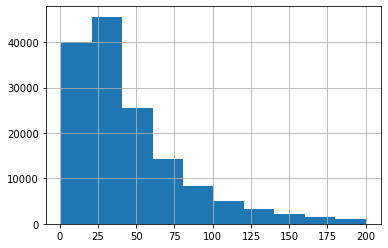

In [16]:
(train[train.units_sold <= 200].units_sold).hist()

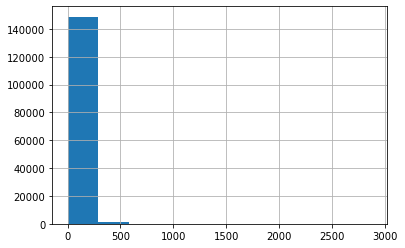

In [17]:
train['units_sold'].hist()

Notice that the target data is highly skewed. To make accurate predictions, we must normalise it before using.

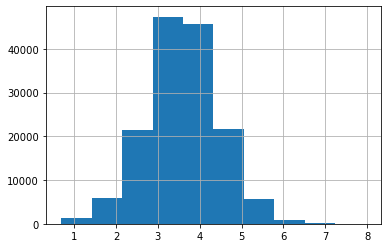

In [18]:
np.log1p(train['units_sold']).hist()

Comparing for base and total price. Let's see if we can gain some insights about the target data from these two.

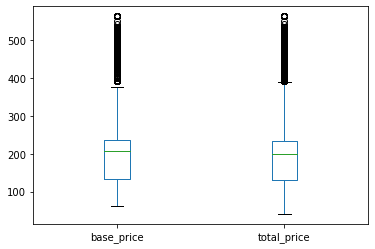

In [19]:
data[['base_price', 'total_price']].plot.box()

In [20]:
# Making price based new features

train['diff'] = train['base_price'] - train['total_price']

train['relative_diff_base'] = train['diff']/train['base_price']
train['relative_diff_total'] = train['diff']/train['total_price']

train.head(2)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku,diff,relative_diff_base,relative_diff_total
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20,8091_216418,12.825,0.11465,0.129496
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28,8091_216419,0.000,0.00000,0.000000


In [21]:
test['diff'] = test['base_price'] - test['total_price']
test['relative_diff_base'] = test['diff']/test['base_price']
test['relative_diff_total'] = test['diff']/test['total_price']
test.head(2)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,store_sku,units_sold,diff,relative_diff_base,relative_diff_total
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0,8091_216418,-1,0.0,0.0,0.0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0,8091_216419,-1,0.0,0.0,0.0


In [22]:
# Studying correlation between features and the target. This will help us in regression later.
cols = ['base_price', 'total_price', 'diff', 'relative_diff_base', 'relative_diff_total'
        , 'is_featured_sku', 'is_display_sku', 'units_sold']
train[cols].corr().loc['units_sold']

base_price            -0.140032
total_price           -0.235634
diff                   0.278283
relative_diff_base     0.364841
relative_diff_total    0.365690
is_featured_sku        0.337751
is_display_sku         0.362662
units_sold             1.000000
Name: units_sold, dtype: float64

We have good correlation of features with the target variable, hence doing a baseline regression won't be a bad start.

# Baseline Regression

In [23]:
print(f'current # of features in cols: {len(cols)}')
cols.remove('units_sold')
print(f'current # of features to be used: {len(cols)}')

current # of features in cols: 8
current # of features to be used: 7


In [24]:
from sklearn.model_selection import train_test_split

X = train[cols]
y = np.log1p(train['units_sold']) # Transforming target into normal via logarithmic operation

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape)

(120120, 7) (120120,) (30030, 7) (30030,)


In [25]:
Xtrain.isnull().sum()

base_price             0
total_price            0
diff                   0
relative_diff_base     0
relative_diff_total    0
is_featured_sku        0
is_display_sku         0
dtype: int64

In [26]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(Xtrain, ytrain)

RandomForestRegressor()

In [27]:
preds = reg.predict(Xval)
print(f'The validation RMSLE error for baseline model is: {RMSLE(np.exp(yval), np.exp(preds))}')

The validation RMSLE error for baseline model is: 610.9894658316206


In [28]:
sub_preds = reg.predict(test[cols])
submit['units_sold'] = np.exp(sub_preds)
submit.head(2)

,record_ID,units_sold
0,212645,58.946308
1,212646,51.196541


In [29]:
submit.to_csv('sub_baseline_v1.csv', index = False)

#### Leaderboard scores:
- Public: 731.0198
- Private: ?

Not a bad start!
The time series data that we have behaves differently for different sku and hence we should try fitting multiple models for each sku/store, i.e., different models for different store_sku combination. Let's try that out and see if that makes any improvement.

# SKU level base model fitting

Before fitting the model, we would like to encode our store and sku information. There are multiple ways of doing this:
    1. One-hot encoding
    2. Label encoding
    3. Category encoding
Since, the features here have high cardinality, we should go for Category encoding. I'll be using `MEstimateEncoder` for this purpose.
You can find its documentation at this link: http://contrib.scikit-learn.org/category_encoders/mestimate.html

In [30]:
from category_encoders import TargetEncoder, MEstimateEncoder
encoder = MEstimateEncoder()
encoder.fit(train['store_id'], train['units_sold'])
train['store_encoded'] = encoder.transform(train['store_id'], train['units_sold'])
test['store_encoded'] = encoder.transform(test['store_id'], test['units_sold'])

In [31]:
encoder.fit(train['sku_id'], train['units_sold'])
train['sku_encoded'] = encoder.transform(train['sku_id'], train['units_sold'])
test['sku_encoded'] = encoder.transform(test['sku_id'], test['units_sold'])

In [32]:
skus = train.sku_id.unique()
print(skus[:2])

test_preds = test.copy()
test_preds.tail(2)

[216418 216419]


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,store_sku,units_sold,diff,relative_diff_base,relative_diff_total,store_encoded,sku_encoded
13858,232286,01/10/13,9984,547934,191.6625,191.6625,0,0,9984_547934,-1,0.0,0.0,0.0,9984,547934
13859,232287,01/10/13,9984,679023,234.4125,234.4125,0,0,9984_679023,-1,0.0,0.0,0.0,9984,679023


In [33]:
def sku_model(sku, cols_to_use, reg):
    X = train[train['sku_id'] == sku][cols_to_use]
    y = train[train['sku_id'] == sku]['units_sold']
    
    Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
    reg.fit(X,np.log1p(y))
    
    y_pred = reg.predict(Xval)
    err = RMSLE(yval, np.exp(y_pred))
    print(f'RMSLE for {sku} is: {err}')
    
    preds = reg.predict(test[test['sku_id'] == sku][cols_to_use])    
    temp_df =  pd.DataFrame.from_dict({'record_ID': test_preds[test_preds['sku_id'] == sku]['record_ID'],
                                       'units_sold':  np.exp(preds)})
    return err, temp_df

In [34]:
cols_to_use = cols + ['store_encoded', 'sku_encoded']

In [35]:
err = dict() # for documenting error for each sku type
sub = pd.DataFrame(None, columns = ['record_ID', 'units_sold'])
reg = RandomForestRegressor(random_state = 2288)

for sku in skus:
    err[sku], temp = sku_model(sku, cols_to_use, reg)
    sub = sub.append(temp)

print(np.mean(list(err.values())))

RMSLE for 216418 is: 250.4987659580474
RMSLE for 216419 is: 258.0353713207114
RMSLE for 216425 is: 346.6434975892215
RMSLE for 216233 is: 296.1346670883805
RMSLE for 217390 is: 245.41850879722884
RMSLE for 219009 is: 230.05247298242153
RMSLE for 219029 is: 313.87562496715077
RMSLE for 223245 is: 295.7498915904871
RMSLE for 223153 is: 372.28214512570395
RMSLE for 300021 is: 331.010100275212
RMSLE for 219844 is: 327.1913105617335
RMSLE for 222087 is: 217.96534609073692
RMSLE for 320485 is: 340.274443481082
RMSLE for 378934 is: 388.5441435816927
RMSLE for 222765 is: 328.7940645047455
RMSLE for 245387 is: 375.61906496621907
RMSLE for 245338 is: 354.81432132638844
RMSLE for 547934 is: 418.4927864299167
RMSLE for 300291 is: 410.0506032501063
RMSLE for 217217 is: 360.1444679481536
RMSLE for 217777 is: 347.10487222928765
RMSLE for 398721 is: 464.81256491657297
RMSLE for 679023 is: 437.4374897591102
RMSLE for 546789 is: 355.95802950156303
RMSLE for 600934 is: 394.82255825194864
RMSLE for 545621

In [36]:
sub.sort_values(by = ['record_ID']).to_csv('sub_sku_RF_v2.csv', index = False)

Till now we have done:
- RF regressor for all data at once: Public LB score `731.0198`
- RF regressor for data at sku level: Public LB score `481.0016`

Wow! That's a huge improvement. This proves that using data at sku level will certainly help the cause.

Now, we would also like to incorporate the `store_id` as one of the defining features of the multiple models that we are building. But as the problem statement defines, there are 76 different models for each one of them across each sku will be a herculean task. 
Then, how do we do it?

We will be using LightGBM's categorical features' input to our rescue. This can be used to provide categorical inputs to the model with a single line of code. Moreover, as the documentation says, it is 8 times faster than one-hot encoding. Find its link here.
https://lightgbm.readthedocs.io/en/latest/Parameters.html#categorical_feature

# LightGBM Regressor

In [37]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, StratifiedKFold

In [38]:
cols_to_use

['base_price',
 'total_price',
 'diff',
 'relative_diff_base',
 'relative_diff_total',
 'is_featured_sku',
 'is_display_sku',
 'store_encoded',
 'sku_encoded']

In [39]:
cols_to_use += ['store_id', 'sku_id']
# For defining categorical features to the model, we will build `cat_cols`
cat_cols = ['is_featured_sku', 'is_display_sku', 'store_id', 'sku_id']

In [40]:
X = train[cols_to_use]
y = np.log1p(train['units_sold']) # Transforming target into normal via logarithmic operation

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape)

(120120, 11) (120120,) (30030, 11) (30030,)


In [41]:
Xtest = test[cols_to_use]

In [42]:
def runLGB(Xtrain, ytrain, Xval, yval, cat_cols, Xtest = None):
    params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l1',
    #'max_depth': 9, 
    'learning_rate': 0.1
    ,'verbose': 1
    , "min_data_in_leaf" : 10
    }

    n_estimators = 800
    early_stopping_rounds = 10

    d_train = lgb.Dataset(Xtrain.copy(), label=ytrain.copy(), categorical_feature=cat_cols)
    d_valid = lgb.Dataset(Xval.copy(), label=yval.copy(), categorical_feature=cat_cols)
    watchlist = [d_train, d_valid]

    model = lgb.train(params, d_train, n_estimators
                      , valid_sets = [d_train, d_valid]
                      , verbose_eval=n_estimators
                      , early_stopping_rounds=early_stopping_rounds)

    preds = model.predict(Xval, num_iteration=model.best_iteration)
    err = RMSLE(yval, np.exp(preds))
    
    preds_test = model.predict(Xtest, num_iteration=model.best_iteration)
    return  preds, err, np.exp(preds_test), model

In [43]:
pred_val, err, pred_test,model = runLGB(Xtrain, ytrain, Xval, yval, cat_cols, Xtest)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[588]	training's l1: 0.268272	valid_1's l1: 0.286406


- Public LB score: 419.7016
- Private LB score: ?

In [44]:
submit['units_sold'] = pred_test
submit.to_csv('lgb_sub_store_sku_v3.csv', index = False)

In [45]:
a =model.feature_importance(importance_type='split')
feature = pd.DataFrame(model.feature_name(), columns = ['feature'])
feature['importance'] = a
feature = feature.sort_values(by = ['importance'], ascending = False)
feature.head(11)

,feature,importance
9,store_id,4523
0,base_price,2765
1,total_price,2674
10,sku_id,1823
2,diff,1556
3,relative_diff_base,1331
7,store_encoded,1182
8,sku_encoded,780
5,is_featured_sku,515
6,is_display_sku,488


Without using any date and time features, we have scored `419.7016` on LB which is a huge improvement.
Let's see if we can extract any useful information from the `week` feature.
We will try to build numeric features based on the week's start as well as end date. <br>
I'll also be using 5-fold CV to strengthen the predictions later.

# Extracting datetime features

In [46]:
from datetime import datetime
train['week'] = train['week'].astype('str')
train['week'] = [datetime.strptime(x, '%d/%m/%y') for x in train['week']]

In [47]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku,diff,relative_diff_base,relative_diff_total,store_encoded,sku_encoded
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,8091_216418,12.825,0.11465,0.129496,8091,216418
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,8091_216419,0.000,0.00000,0.000000,8091,216419
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,8091_216425,0.000,0.00000,0.000000,8091,216425
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,8091_216233,0.000,0.00000,0.000000,8091,216233
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,8091_217390,0.000,0.00000,0.000000,8091,217390


In [48]:
test['week'] = test['week'].astype('str')
test['week'] = [datetime.strptime(x, '%d/%m/%y') for x in test['week']]

In [49]:
import datetime
train['weekend_date'] = [x + datetime.timedelta(days=6) for x in train['week']]
test['weekend_date'] = [x + datetime.timedelta(days=6) for x in test['week']]

In [50]:
current_cols = list(train.columns)

In [51]:
import datetime 
def extract_time_features(df):
    
    start_date = datetime.datetime(2011,1, 17)
    
    print('starting basic feature extraction for week start date!')

    df['year'] = df['week'].dt.year
    df['date'] = [x.day for x in df['week']]
    df['month'] = df['week'].dt.month
    df['weekday'] = df['week'].dt.dayofweek
    df['weeknum'] = df['week'].dt.weekofyear
    
    df['week_serial']  = [divmod((x-start_date).total_seconds(), 86400)[0]/7 for x in df['week']]
    

    '''
    print('starting month end related feature extraction for week start date!')

    df['quarter'] = [x.quarter for x in df['week']]
    df['is_month_start'] = [x.is_month_start for x in df['week']]
    df['is_month_end'] = [x.is_month_end for x in df['week']]
    df['is_month_start'] = df['is_month_start'].astype(int)
    df['is_month_end'] = df['is_month_end'].astype(int)
    
    df['start_week']= df.assign(start_week=pd.cut(df.date,[0,9,15,23,31],labels=[1,2,3,4]))['start_week']
    df['start_week'] = df['start_week'].astype(int)
    '''

    print('Starting basic feature extraction for week end date!')
    
    df['end_year'] = df['weekend_date'].dt.year
    df['end_date'] = [x.day for x in df['weekend_date']]
    df['end_month'] = df['weekend_date'].dt.month
    df['end_weekday'] = df['weekend_date'].dt.dayofweek
    df['end_weeknum'] = df['weekend_date'].dt.weekofyear
    df['end_week_serial']  = [divmod((x-start_date).total_seconds(), 86400)[0]/7 for x in df['weekend_date']]

    '''
    print('starting month end related feature extraction for week start date!')

    df['end_quarter'] = [x.quarter for x in df['weekend_date']]
    df['end_is_month_start'] = [x.is_month_start for x in df['weekend_date']]
    df['end_is_month_end'] = [x.is_month_end for x in df['weekend_date']]
    df['end_is_month_start'] = df['end_is_month_start'].astype(int)
    df['end_is_month_end'] = df['end_is_month_end'].astype(int)
    
    df['end_week'] = df.assign(end_week=pd.cut(df.end_date,[0,9,15,23,31],labels=[1,2,3,4]))['end_week']
    df['end_week'] = df['end_week'].astype(int)
    '''
    return df

In [52]:
train = extract_time_features(train)
train.tail()

starting basic feature extraction for week start date!
Starting basic feature extraction for week end date!


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku,...,month,weekday,weeknum,week_serial,end_year,end_date,end_month,end_weekday,end_weeknum,end_week_serial
150145,212638,2013-07-09,9984,223245,235.8375,235.8375,0,0,38,9984_223245,...,7,1,28,129.142857,2013,15,7,0,29,130.0
150146,212639,2013-07-09,9984,223153,235.8375,235.8375,0,0,30,9984_223153,...,7,1,28,129.142857,2013,15,7,0,29,130.0
150147,212642,2013-07-09,9984,245338,357.6750,483.7875,1,1,31,9984_245338,...,7,1,28,129.142857,2013,15,7,0,29,130.0
150148,212643,2013-07-09,9984,547934,141.7875,191.6625,0,1,12,9984_547934,...,7,1,28,129.142857,2013,15,7,0,29,130.0
150149,212644,2013-07-09,9984,679023,234.4125,234.4125,0,0,15,9984_679023,...,7,1,28,129.142857,2013,15,7,0,29,130.0


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   record_ID            150150 non-null  int64         
 1   week                 150150 non-null  datetime64[ns]
 2   store_id             150150 non-null  int64         
 3   sku_id               150150 non-null  int64         
 4   total_price          150150 non-null  float64       
 5   base_price           150150 non-null  float64       
 6   is_featured_sku      150150 non-null  int64         
 7   is_display_sku       150150 non-null  int64         
 8   units_sold           150150 non-null  int64         
 9   store_sku            150150 non-null  object        
 10  diff                 150150 non-null  float64       
 11  relative_diff_base   150150 non-null  float64       
 12  relative_diff_total  150150 non-null  float64       
 13  store_encoded 

In [54]:
test = extract_time_features(test)
test.tail()

starting basic feature extraction for week start date!
Starting basic feature extraction for week end date!


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,store_sku,units_sold,...,month,weekday,weeknum,week_serial,end_year,end_date,end_month,end_weekday,end_weeknum,end_week_serial
13855,232281,2013-10-01,9984,223245,241.5375,241.5375,0,0,9984_223245,-1,...,10,1,40,141.142857,2013,7,10,0,41,142.0
13856,232282,2013-10-01,9984,223153,240.8250,240.8250,0,0,9984_223153,-1,...,10,1,40,141.142857,2013,7,10,0,41,142.0
13857,232285,2013-10-01,9984,245338,382.6125,401.8500,1,1,9984_245338,-1,...,10,1,40,141.142857,2013,7,10,0,41,142.0
13858,232286,2013-10-01,9984,547934,191.6625,191.6625,0,0,9984_547934,-1,...,10,1,40,141.142857,2013,7,10,0,41,142.0
13859,232287,2013-10-01,9984,679023,234.4125,234.4125,0,0,9984_679023,-1,...,10,1,40,141.142857,2013,7,10,0,41,142.0


In [55]:
def Diff(li1, li2): 
    return list(set(li1) - set(li2))

total_cols = list(test.columns)
new_feat = Diff(total_cols, current_cols)
new_feat

['date',
 'end_week_serial',
 'month',
 'week_serial',
 'year',
 'weekday',
 'weeknum',
 'end_weekday',
 'end_month',
 'end_weeknum',
 'end_date',
 'end_year']

In [56]:
train[new_feat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             150150 non-null  int64  
 1   end_week_serial  150150 non-null  float64
 2   month            150150 non-null  int64  
 3   week_serial      150150 non-null  float64
 4   year             150150 non-null  int64  
 5   weekday          150150 non-null  int64  
 6   weeknum          150150 non-null  int64  
 7   end_weekday      150150 non-null  int64  
 8   end_month        150150 non-null  int64  
 9   end_weeknum      150150 non-null  int64  
 10  end_date         150150 non-null  int64  
 11  end_year         150150 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 13.7 MB


## Training LGB Model with all the date/time features created

In [57]:
print(f'The number of features used before: {len(cols_to_use)}')
print(f'The number of categorical features used before: {len(cat_cols)}')

The number of features used before: 11
The number of categorical features used before: 4


In [58]:
cols_to_use += new_feat
#cat_cols += new_feat

print(f'The number of features to be used now: {len(cols_to_use)}')
print(f'The number of categorical features to be used now: {len(cat_cols)}')

The number of features to be used now: 23
The number of categorical features to be used now: 4


In [59]:
cols_to_use

['base_price',
 'total_price',
 'diff',
 'relative_diff_base',
 'relative_diff_total',
 'is_featured_sku',
 'is_display_sku',
 'store_encoded',
 'sku_encoded',
 'store_id',
 'sku_id',
 'date',
 'end_week_serial',
 'month',
 'week_serial',
 'year',
 'weekday',
 'weeknum',
 'end_weekday',
 'end_month',
 'end_weeknum',
 'end_date',
 'end_year']

In [60]:
Xtest = test[cols_to_use]

In [61]:
X = train[cols_to_use]
y = np.log1p(train['units_sold']) # Transforming target into normal via logarithmic operation

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape)

(120120, 23) (120120,) (30030, 23) (30030,)


In [62]:
pred_val, err, pred_test,model = runLGB(Xtrain, ytrain, Xval, yval, cat_cols, Xtest)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[800]	training's l1: 0.211339	valid_1's l1: 0.244047
Did not meet early stopping. Best iteration is:
[800]	training's l1: 0.211339	valid_1's l1: 0.244047


In [63]:
submit['units_sold'] = pred_test
submit.to_csv('lgb_time_store_sku_v4.csv', index = False)

- Public LB score: 377.3146
- Private LB score: 

In [64]:
a =model.feature_importance(importance_type='split')
feature = pd.DataFrame(model.feature_name(), columns = ['feature'])
feature['importance'] = a
feature = feature.sort_values(by = ['importance'], ascending = False)
feature.head(20)

,feature,importance
9,store_id,6386
10,sku_id,3349
12,end_week_serial,2947
1,total_price,1841
0,base_price,1562
11,date,1353
2,diff,875
21,end_date,839
20,end_weeknum,772
17,weeknum,770


In [65]:
# making changes in the LGB model to improve the predictions (Tuning!)
def runLGB2(Xtrain, ytrain, Xval, yval, cat_cols, Xtest = None):
    params = {
    'boosting_type': 'dart', #dropout aided regressive trees (DART) # improves accuracy
    'objective': 'regression',
    'metric': 'l1', 
    #'max_depth': 10, 
    'learning_rate': 0.5
    ,'verbose': 1
    }
    
    #regularising for overfitting with inf depth
    params["min_data_in_leaf"] = 15 
    params["bagging_fraction"] = 0.7
    params["feature_fraction"] = 0.7
    #params["bagging_freq"] = 3
    params["bagging_seed"] = 50

    n_estimators = 575
    early_stopping_rounds = 30

    d_train = lgb.Dataset(Xtrain.copy(), label=np.log1p(ytrain.copy()), categorical_feature=cat_cols)
    d_valid = lgb.Dataset(Xval.copy(), label=np.log1p(yval.copy()), categorical_feature=cat_cols)
    watchlist = [d_train, d_valid]

    model = lgb.train(params, d_train, n_estimators
                      , valid_sets = [d_train, d_valid]
                      , verbose_eval=125
                      , early_stopping_rounds=early_stopping_rounds)

    preds = model.predict(Xval, num_iteration=model.best_iteration)
    err = RMSLE(yval['units_sold'], np.exp(preds))
    
    preds_test = np.exp(model.predict(Xtest, num_iteration=model.best_iteration))
    return  preds, err, preds_test, model

In [66]:
encoder.fit(train[new_feat], train['units_sold'])
train[new_feat] = encoder.transform(train[new_feat], train['units_sold'])
test[new_feat] = encoder.transform(test[new_feat], test['units_sold'])

In [67]:
import time

preds_buff = 0
err_buff = []

X = train[cols_to_use]
y = train[['units_sold']]

n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle= True, random_state=22)

for dev_index, val_index in kf.split(X, y):
    start = time.time()
    Xtrain, Xval = X.iloc[dev_index], X.iloc[val_index]
    ytrain, yval = y.iloc[dev_index], y.iloc[val_index]    
    
    pred_val, err, pred_test,model = runLGB2(Xtrain, ytrain, Xval, yval, cat_cols, Xtest)
    preds_buff += pred_test
    err_buff.append(err)
    print(f'Mean Error: {np.mean(err_buff)}; Split error: {err}')
    print(f'Total time in seconds for this fold: {time.time()-start}')
    print('\n')

preds_buff /= n_splits

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[125]	training's l1: 0.257508	valid_1's l1: 0.265041
[250]	training's l1: 0.238582	valid_1's l1: 0.250709
[375]	training's l1: 0.228277	valid_1's l1: 0.245041
[500]	training's l1: 0.219221	valid_1's l1: 0.241851
Mean Error: 327.36714493890435; Split error: 327.36714493890435
Total time in seconds for this fold: 64.15344309806824


[125]	training's l1: 0.257076	valid_1's l1: 0.264194
[250]	training's l1: 0.238578	valid_1's l1: 0.250141
[375]	training's l1: 0.228269	valid_1's l1: 0.244139
[500]	training's l1: 0.218912	valid_1's l1: 0.241
Mean Error: 325.19316154913395; Split error: 323.0191781593635
Total time in seconds for this fold: 56.12279677391052


[125]	training's l1: 0.257214	valid_1's l1: 0.266653
[250]	training's l1: 0.23843	valid_1's l1: 0.252723
[375]	training's l1: 0.228223	valid_1's l1: 0.246228
[500]	training's l1: 0.219286	valid_1's l1: 0.244102
Mean Error: 326.0740426211264; Split error: 327.8358047651114
Total time in seconds for this fold: 57.94218969345093


[125]	tr

In [68]:
print(err_buff, np.mean(err_buff))

[327.36714493890435, 323.0191781593635, 327.8358047651114, 325.10458611450474, 330.51475626477253, 328.39147179873055, 326.2858348739058, 330.701573378871, 328.6204110121856, 329.80771238948364] 327.7648473695833


In [69]:
submit['units_sold'] = np.abs(preds_buff)
submit.to_csv('lgb_time_10cv_v5.csv', index = False)

Leaderboard scores:
1. After adding basic time related features
    - Public LB score: 363.6342
    - Private LB score: ?
2. After encoding time related features
    - Public LB score: 365.7862
    - Private LB score: ?
3. After fine-tuning the hyperparameters with 10 fold CV
    - Public LB score: 360.7086
    - Private LB score: ?

In [70]:
a =model.feature_importance(importance_type='split')
feature = pd.DataFrame(model.feature_name(), columns = ['feature'])
feature['importance'] = a
feature = feature.sort_values(by = ['importance'], ascending = False)
feature.head(20)

,feature,importance
9,store_id,4283
10,sku_id,2451
1,total_price,1576
12,end_week_serial,1540
0,base_price,1240
8,sku_encoded,960
3,relative_diff_base,603
11,date,592
17,weeknum,562
2,diff,517


In [71]:
submit.head()

,record_ID,units_sold
0,212645,21.163058
1,212646,23.675132
2,212647,34.839319
3,212648,31.773779
4,212649,24.315106
